In [1]:
%autosave 60
import matplotlib.pyplot as plt
import numpy as np
from nexusformat.nexus import nxload

class Nexus_handling:
    def get_nexus_data_I06(self,file):
        """Function that loads the data from a nexus file and returns it as a list of numpy
arrays"""
        entry_string = "entry"
        data_region_list = []
        metadata_region_list = None
        x_array = file[entry_string]["instrument"]["fastEnergy"]["value"].nxvalue
        y_array = file[entry_string]["instrument"]["fesData"]["C1"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["C5"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["idio"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["ifiofb"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        magnet_field = file[entry_string]["instrument"]["scm"]["field_z"].nxvalue
        metadata_region_list = {"magnet_ﬁeld": magnet_field}
        polar = file[entry_string]["instrument"]["id"]["polarisation"].nxvalue
        metadata_region_list["polarisation"] = polar
        ###Add temperature values here
        ### Add angle of the beam here => 
        return data_region_list, metadata_region_list

    def open_single_spectra(self,ﬁle_number,directory_path,ﬁle_preﬁx,sensor):
        ﬁle_name = directory_path + ﬁle_preﬁx + str(ﬁle_number) + ".nxs"
        spectra_ﬁle = nxload(ﬁle_name)
        data,meta_data = self.get_nexus_data_I06(spectra_ﬁle)
        if sensor == "TEY":
            spectra = {"x" : data[2]["x"],"y":data[2]["y"],"meta" : meta_data}
        elif sensor == "TFY":
            spectra = {"x" : data[3]["x"],"y":data[3]["y"],"meta" : meta_data}
        return spectra

class XMCD_data_analysis(Nexus_handling):
    def __init__(self):
        self.on_oI_edge_points = [571, 576.9]
        self.directory_path = None
        self.ﬁle_preﬁx = None
        self.energy = None
        self.spectra = []
        self.hyst = []
        self.XMCD = []
        self.magz = []
        #self.temperature
    
    def set_directory_path(self, directory_path):
        self.directory_path = directory_path

    def set_ﬁle_preﬁx(self, ﬁle_preﬁx):
        self.ﬁle_preﬁx = ﬁle_preﬁx

    def load_spectra(self, directory_path, ﬁle_preﬁx, XMCD_spectra_Set,sensor = "TEY"):  
        self.directory_path = directory_path
        self.ﬁle_preﬁx = ﬁle_preﬁx

        if len(XMCD_spectra_Set) != 1:
            for ﬁle_number in XMCD_spectra_Set: 
                print(file_number)
                data_set = self.open_single_spectra(ﬁle_number, directory_path,  ﬁle_preﬁx,sensor)
                self.spectra.append(data_set)
                self.energy = self.spectra[0]["x"]
        else:
            print(XMCD_spectra_Set)
            data_set = self.open_single_spectra(XMCD_spectra_Set[0], directory_path,  ﬁle_preﬁx,sensor)
            self.spectra.append(data_set)
    
            self.energy = self.spectra[0]["x"]
#######################################################################################
    ### Plotting functions
    
    def plot_spectra(self,XAS_file_Set,i, bounds = None, normalisation = None):
        #Plots a single XAS spectra out of a set 
        #XAS_file_set : a set of XAS scan numbers
        #i : the indice of which scan you want to plot
        Energy,Idio = XMCD.spectra[i]["x"],XMCD.spectra[i]["y"]
        if bounds is not None:
            plt.xlim(bounds[0])
            plt.ylim(bounds[1])

        if normalisation is not None:
            value = np.mean(Idio[:normalisation])
            plotting_y = Idio - value
            plotting_y = plotting_y / np.max(plotting_y) 
        else:
            plotting_y = Idio

        
        plt.plot(Energy,plotting_y,label = XAS_file_Set[i])
        plt.title(("XAS ",sensor,XAS_file_set[i],self.spectra[i]["meta"]["polarisation"]))
        plt.legend()
        plt.xlabel("Energy(eV)")
        plt.ylabel("idio")   

    def Dichroism(self,XMCD_ﬁle_Set, avg = "Before"):
        #Takes in a series of XAS spectra of opposing polarisations then averages all the nc and all the pc and subtracts them to give us the dichroism
        # XMCD_file_Set : list of XAS spectra, at a minimum we need one of each polarisation of light.
        fig = plt.figure(figsize=(12, 6))
        ax = fig.subplots(1,3, sharey=True)  # (nrows, ncols, index)
        
        nc_storage = np.zeros(len(self.energy))
        pc_storage = np.zeros(len(self.energy))
        
        B_Field = self.spectra[0]["meta"]["magnet_ﬁeld"]
        fig.suptitle("Dichroism at " + str(np.round(B_Field)) +  "T ")
        print(B_Field)
        ax[0].set_title("pc")
        ax[1].set_title("nc")
        ax[2].set_title("XMCD")
        
        ax[1].set_xlabel("energy (eV")
        ax[0].set_ylabel("idio")
        
        n,m = 0,0
        for i in range(0,len(XMCD_file_Set)):
            Polarisation = self.spectra[i]["meta"]["polarisation"]
            F = self.spectra[i]["y"]
            f=np.polyfit(self.energy, F, 1)
            fit=np.polyval(f,self.energy)
            if Polarisation == "nc":
                nc_storage += F
                n += 1
                ax[0].plot(self.energy,(F-fit)+0.1,label = XMCD_file_Set[i] )
                ax[0].legend()
            elif Polarisation == "pc":
                pc_storage = pc_storage + F
                m = m + 1
                ax[1].plot(self.energy,(F-fit)+0.1,label = XMCD_file_Set[i] )
                ax[1].legend()

        if avg == "Before":
            nc_storage = nc_storage/n
            pc_storage = pc_storage/m
            dichroism = abs(pc_storage) - abs(nc_storage)
        
        ax[2].plot(self.energy,dichroism,label = "XMCD")
        ax[2].legend()

        for axs in ax:
            axs.axhline(y = 0, color = 'b', linestyle = 'dashed') 
            # axs.set_ylim(-0.05, 1)
        return self.energy,dichroism                    

def prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor):
    XMCD = XMCD_data_analysis()
    XMCD.load_spectra(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)
    return XMCD

print("Saved Code")
directory_path = r"FILES/"
ﬁle_preﬁx = "i06-1-"

print("ALL GOOD HERE BOSS")


Autosaving every 60 seconds
Saved Code
ALL GOOD HERE BOSS


347257
347258
0.4005


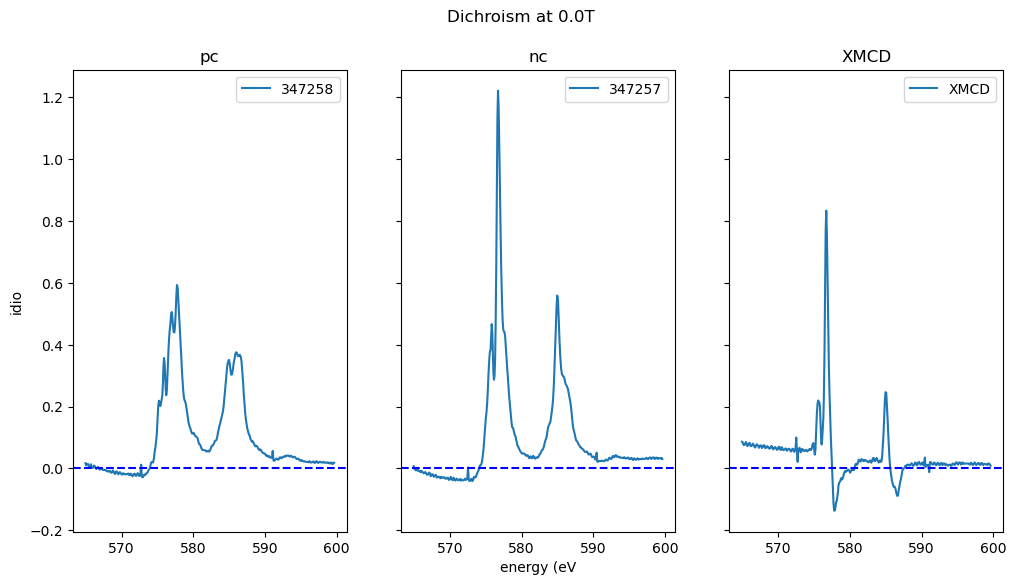

In [2]:
##60deg - 400mT Coercive Field 
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347257,347258)

#2025-01-30 05:08:09,465 INFO  EnergyConsolidationClass:iddrpenergy - delayedSwitchAndMoveEnergy(): iddpol.isBusy()=True


XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 
